### NOTEBOOK WITH CODE - NEIGBORHOOD RECOMMENDED TO OPEN AN ITALIAN RESTAURANT IN TORONTO

### 1.-  INTRODUCTION & DISCUSSION

Toronto is Canada’s largest city and is recognized as one of the most multicultural cities in the world. Toronto is the most populous city in Canada and the capital of Ontario province. Nowadays it is considered an international center of business and finance and it has varied cultural institutions, including museums and galleries, festivals and public events, national historic sites and sport activities. This city attract over 43 million tourists each year and is the place of the headquarters of Canada's five largest banks. While the majority of Torontonians speak English as their primary language, over 160 languages are spoken in the city.

According to Forbes, powerful cities such as Toronto attract investment due to the size of their economy, their projected future prosperity, cost of living and quality of life. The city experiences four distinct seasons, with considerable variance in length. As a result of the rapid passage of weather systems the weather is variable from day to day in all seasons. Toronto encompasses a geographical area formerly administered by many separate municipalities. These municipalities have each developed a distinct history and identity over the years, and their names remain in common use among Torontonians.

Since Toronto is one of the world’s top cities to invest in and for starting a company and has become an important destination for immigrants to Canada, where more tan 50% of the residents belong to an especific population group, this project will try to recommend which neighborhoods are more suitable to open an Italian restaurant. Besides, sinde acording to the data (2017) Italian is placed in the top 20 of ethnic origins in this city with almost 7% of the total population, it would be a great business idea to start a restaurant in certian neigborhoods that provide a higher profit.


### 2.- DESCRIPTION OF THE DATA AND HOW IT WILL BE USED

#### 2.1.- DATA

Regarding to the data, the following information will be used in the project:

1) https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M - “List of Postal code of Canada: M”: Information related to all the neighborhoods in Toronto. 

2) https://cocl.us/Geospatial_data”: A csv file that contain all the geographical coordinates of the neighborhoods.

3) https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversityTo - “Demographics of Toronto”: Information about the distribution of population by their ethnicity. 

4) https://developer.foursquare.com/docs - Foursquare API: Information about location and venues in Toronto


#### 2.2.- HOW DATA WILL BE USED

From “List of Postal code of Canada: M” Wikipedia page, I will get the information of all the neighborhoods in Toronto. Through scraping on that page I will get data such as postal code, borough and the neighborhoods. Using the csv file from https://cocl.us/Geospatial_data” I will add geographical coordinates to those neighborhoods. 

From “Demographics of Toronto” Wikipedia page, I will scrap the distribution of population to identify neighborhoods which are densely populated with Italians. Using Foursquare's API, I will retrieve information about the venues in the neighborhoods of Toronto (names, categories and locations). After that I will focus on Italian Restaurant information extracted.

In the exploratory analysis I will find a relationship between Neighborhood and Italian population and after that I will look for a relationship between Italian population and Italian restaurant. Finally I will apply a predictive modeling using K-means clustering to analyze each cluster found and give recommendations.


### 3.- METHODOLOGY

#### 3.1.- GETTING DATA & PREPROCESSING

#### Toronto Neighborhoods - Scraping from Wikipedia

In [24]:
!conda install -c conda-forge wikipedia --yes 

import pandas as pd
import numpy as np
import wikipedia as wp

Solving environment: done

# All requested packages already installed.



List of Postal code of Canada: M form Wikipedia

In [25]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html, header = 0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Process cells just with Borough assigned and if a cell has a borough but a Not assigned neighborhood, then the neighborhood is the same as the borough

In [26]:
df = df[df.Borough != 'Not assigned']

df['Neighbourhood']=df['Neighbourhood'].replace('Not assigned', df['Borough'])
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [27]:
df = df.groupby(['Borough', 'Postcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


#### Neighborhoods with coordinates

Latitude & longitud from CSV file

In [28]:
import io
import requests

url = "https://cocl.us/Geospatial_data"
lat_long = requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df = lat_long_df.rename(columns={'Postal Code': 'Postcode'})
lat_long_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging dataframes (matching Postcode)

In [29]:
toronto_DF = pd.merge(df,lat_long_df, on='Postcode')
toronto_DF = toronto_DF.rename(columns={'Neighbourhood':'Neighborhood'})
toronto_DF.head()

,Borough,Postcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


#### Demographics of Toronto - Scraping from Wikipedia

In [30]:
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

Toronto & East York

In [31]:
T_E_population_df = pd.read_html(html, header = 0)[13]
T_E_population_df = T_E_population_df.rename(columns={'%':'% EO1 ', 
                                                      '%.1':'% EO2',
                                                     '%.2':'% EO3',
                                                     '%.3':'% EO4',
                                                     '%.4':'% EO5',
                                                     '%.5':'% EO6',
                                                     '%.6':'% EO7',
                                                     '%.7':'% EO8',
                                                     '%.8':'% EO9'})
T_E_population_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8,Ethnic Origin #9,% EO9
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


North York

In [32]:
NY_population_df = pd.read_html(html, header = 0)[14]
NY_population_df = NY_population_df.rename(columns={'%':'% EO1', 
                                                      '%.1':'% EO2',
                                                     '%.2':'% EO3',
                                                     '%.3':'% EO4',
                                                     '%.4':'% EO5',
                                                     '%.5':'% EO6',
                                                     '%.6':'% EO7',
                                                     '%.7':'% EO8'})
NY_population_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


Scarborough

In [33]:
SB_population_df = pd.read_html(html, header = 0)[15]
SB_population_df = SB_population_df.rename(columns={'%':'% EO1', 
                                                      '%.1':'% EO2',
                                                     '%.2':'% EO3',
                                                     '%.3':'% EO4',
                                                     '%.4':'% EO5',
                                                     '%.5':'% EO6',
                                                     '%.6':'% EO7',
                                                     '%.7':'% EO8'})
SB_population_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Etobicoke & York

In [34]:
E_Y_population_df = pd.read_html(html, header = 0)[16]
E_Y_population_df = E_Y_population_df.rename(columns={'%':'% EO1', 
                                                      '%.1':'% EO2',
                                                     '%.2':'% EO3',
                                                     '%.3':'% EO4',
                                                     '%.4':'% EO5',
                                                     '%.5':'% EO6',
                                                     '%.6':'% EO7',
                                                     '%.7':'% EO8'})
E_Y_population_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Getting location - Foursquare

In [35]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [36]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of Toronto: {}, {}.'.format(latitude, longitude))

Coordinates of Toronto: 43.653963, -79.387207.


In [37]:
CLIENT_ID = 'RVY20ETWBXIX3CH001SDLK43P3U4RSZJR5SS4JFVU0JC5IQO' 
CLIENT_SECRET = 'LBQX5SMTTHBK4S4TQ5XFCI532K3HR1MK0J1QM1GQZ4V5HO4Z' 
VERSION = '20180605'
LIMIT = '100'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RVY20ETWBXIX3CH001SDLK43P3U4RSZJR5SS4JFVU0JC5IQO
CLIENT_SECRET:LBQX5SMTTHBK4S4TQ5XFCI532K3HR1MK0J1QM1GQZ4V5HO4Z


In [38]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

Getting categories

In [39]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

With get_category_type function, we clean up the json and covert into a pandas dataframe

In [40]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Cafe Plenty,Café,43.654571,-79.389450


Exploring nearby venues

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [48]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens, Parkview Hill
Woodbine Heights
Leaside
Thorncl

In [49]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Dim Sum Deluxe,43.726953,-79.394260,Dim Sum Restaurant
2,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot


In [50]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",8,8,8,8,8,8
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,56,56,56,56,56,56


In [51]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


One hot encoding to get dummies of venue category. Then we calculate mean of all venue groupby there neighborhoods.

In [52]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.00
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [53]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop                      192
Café                              98
Restaurant                        61
Pizza Place                       55
Italian Restaurant                53
Park                              52
Bakery                            50
Bar                               44
Hotel                             43
Sandwich Place                    41
Clothing Store                    38
Fast Food Restaurant              31
Gym                               31
Japanese Restaurant               30
American Restaurant               30
Breakfast Spot                    29
Sushi Restaurant                  28
Burger Joint                      27
Pub                               25
Chinese Restaurant                25
Seafood Restaurant                24
Gastropub                         24
Thai Restaurant                   23
Grocery Store                     22
Steakhouse                        21
Ice Cream Shop                    21
Pharmacy                          19
D

#### 3.2.- EXPLORATORY DATA ANALYSIS

In [54]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Extracting the Neighborhood and Italian Restaurant column from toronto_grouped dataframe

In [55]:
toronto_part = toronto_grouped[['Neighborhood', 'Italian Restaurant']]
toronto_part

,Neighborhood,Italian Restaurant
0,"Adelaide, King, Richmond",0.010000
1,Agincourt,0.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000
4,"Alderwood, Long Branch",0.000000
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000
6,Bayview Village,0.000000
7,"Bedford Park, Lawrence Manor East",0.090909
8,Berczy Park,0.035714
9,"Birch Cliff, Cliffside West",0.000000


In [56]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,Postcode,Neighborhood,Latitude,Longitude,Italian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.055556
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
5,Central Toronto,M4V,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,0.000000
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.000000
7,Central Toronto,M5P,"Forest Hill North, Forest Hill West",43.696948,-79.411307,0.000000
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.000000
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.000000


Visualization: Neighborhood vs Italian Restaurants

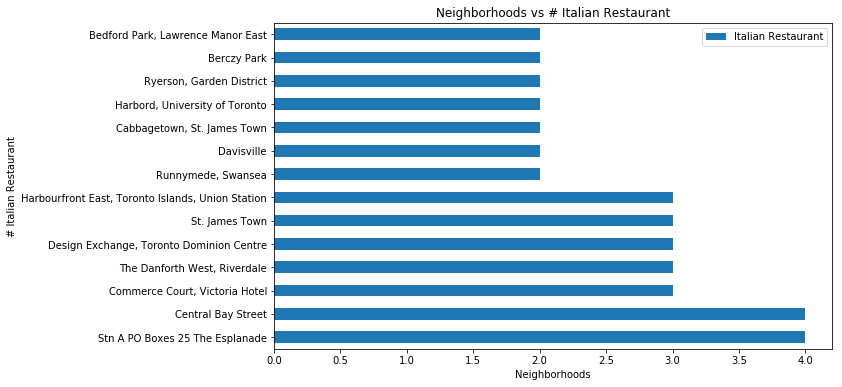

In [58]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Italian Restaurant'].sum())
graph = graph.sort_values(by ='Italian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='barh', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("# Italian Restaurant")
plt.title("Neighborhoods vs # Italian Restaurant")
plt.show()

Merging - Population tables with the ethnic percentage by neighborhood

In [59]:
EYTE = E_Y_population_df.append(T_E_population_df,sort=True).reset_index()
EYTE.drop('index',axis=1,inplace=True)
NYSB = NY_population_df.append(SB_population_df,sort=True).reset_index()
NYSB.drop('index',axis=1,inplace=True)
pop_ethnic_df = NYSB.append(EYTE,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', '% EO1','Ethnic Origin #2', '% EO2',
                               'Ethnic Origin #3','% EO3','Ethnic Origin #4', '% EO4','Ethnic Origin #5','% EO5', 
                               'Ethnic Origin #6','% EO6','Ethnic Origin #7', '% EO7','Ethnic Origin #8', '% EO8',
                               'Ethnic Origin #9','% EO9',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8,Ethnic Origin #9,% EO9
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Picking out the neighborhoods with highest Italian population percentage

In [60]:
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Italian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Italian')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'Italian')]
pop_italian_df = pd.DataFrame(temp).reset_index()
pop_italian_df.drop('index',axis=1,inplace=True)

pop_italian_df

,Riding,Population,Ethnic Origin #1,% EO1,Ethnic Origin #2,% EO2,Ethnic Origin #3,% EO3,Ethnic Origin #4,% EO4,Ethnic Origin #5,% EO5,Ethnic Origin #6,% EO6,Ethnic Origin #7,% EO7,Ethnic Origin #8,% EO8,Ethnic Origin #9,% EO9
0,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4,NaN,NaN
1,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1,NaN,NaN
4,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN,NaN,NaN
5,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Davenport,107395,Portuguese,NaN,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.0,NaN,NaN,NaN,NaN,NaN,NaN
7,Toronto-St. Paul's,104940,English,NaN,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.9,Russian,7.7,Italian,7.3,French,7.2
8,University-Rosedale,100520,English,NaN,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.7,French,7.7,Italian,7.4,NaN,NaN


Italian ethnic percentage & Neighborhood

In [61]:
columns_list = pop_italian_df.columns.to_list()
pop_italian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_italian_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_italian_df.at[i, j] == 'Italian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_italian_DF_with_percent = pop_italian_DF_with_percent.append({'Riding':pop_italian_df.at[i, 'Riding'], 'Population':pop_italian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_italian_df.at[i, j], 'Percentage': pop_italian_df.at[i, percent_col]},ignore_index=True)

pop_italian_DF_with_percent

Ethnic Origin #1
% EO1
Ethnic Origin #2
% EO2
Ethnic Origin #3
% EO3
Ethnic Origin #4
% EO4
Ethnic Origin #5
% EO5
Ethnic Origin #6
% EO6
Ethnic Origin #7
% EO7
Ethnic Origin #8
% EO8
Ethnic Origin #9
% EO9
Ethnic Origin #1
% EO1
Ethnic Origin #2
% EO2
Ethnic Origin #3
% EO3
Ethnic Origin #4
% EO4
Ethnic Origin #5
% EO5
Ethnic Origin #6
% EO6
Ethnic Origin #7
% EO7
Ethnic Origin #8
% EO8
Ethnic Origin #9
% EO9
Ethnic Origin #1
% EO1
Ethnic Origin #2
% EO2
Ethnic Origin #3
% EO3
Ethnic Origin #4
% EO4
Ethnic Origin #5
% EO5
Ethnic Origin #6
% EO6
Ethnic Origin #7
% EO7
Ethnic Origin #8
% EO8
Ethnic Origin #9
% EO9
Ethnic Origin #1
% EO1
Ethnic Origin #2
% EO2
Ethnic Origin #3
% EO3
Ethnic Origin #4
% EO4
Ethnic Origin #5
% EO5
Ethnic Origin #6
% EO6
Ethnic Origin #7
% EO7
Ethnic Origin #8
% EO8
Ethnic Origin #9
% EO9
Ethnic Origin #1
% EO1
Ethnic Origin #2
% EO2
Ethnic Origin #3
% EO3
Ethnic Origin #4
% EO4
Ethnic Origin #5
% EO5
Ethnic Origin #6
% EO6
Ethnic Origin #7
% EO7
Ethnic Orig

,Ethnicity,Percentage,Population,Riding
0,Italian,9.5,112925.0,Eglinton-Lawrence
1,Italian,12.8,107725.0,Humber River-Black Creek
2,Italian,13.4,103760.0,York Centre
3,Italian,9.1,127520.0,Etobicoke-Lakeshore
4,Italian,15.1,116055.0,Etobicoke Centre
5,Italian,12.8,115130.0,York South-Weston
6,Italian,11.1,107395.0,Davenport
7,Italian,7.3,104940.0,Toronto-St. Paul's
8,Italian,7.4,100520.0,University-Rosedale


In [62]:
pop_italian_DF_with_percent['Italian Population'] = (pop_italian_DF_with_percent['Percentage'] * pop_italian_DF_with_percent['Population'])/100
pop_italian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_italian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_italian_DF_with_percent

,Riding,Italian Population
0,Eglinton-Lawrence,10727.875
1,Humber River-Black Creek,13788.800
2,York Centre,13903.840
3,Etobicoke-Lakeshore,11604.320
4,Etobicoke Centre,17524.305
5,York South-Weston,14736.640
6,Davenport,11920.845
7,Toronto-St. Paul's,7660.620
8,University-Rosedale,7438.480


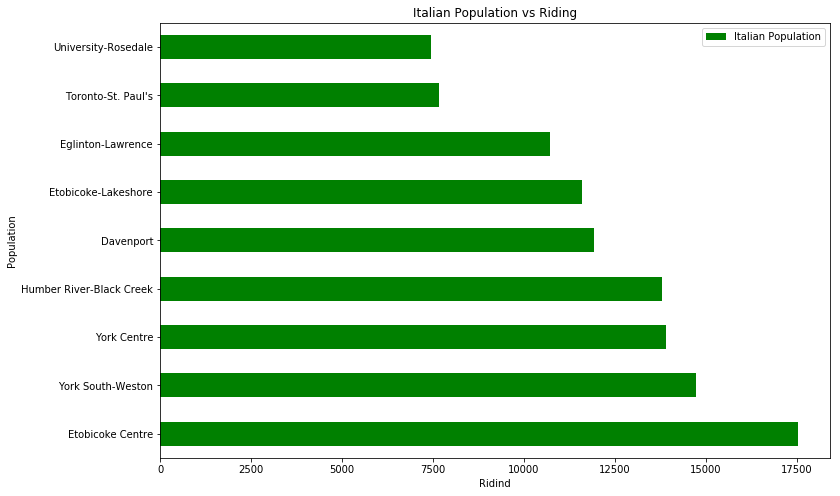

In [63]:
bar_graph = pop_italian_DF_with_percent.sort_values(by='Italian Population', ascending=False)
bar_graph.plot(kind='barh',x='Riding', y='Italian Population',figsize=(12,8), color='green')
plt.title("Italian Population vs Riding")
plt.xlabel("Ridind")
plt.ylabel("Population")
plt.show()

Getting a relationship between Italian population and Italian restaurants

In [64]:
riding_list = pop_italian_DF_with_percent['Riding'].to_list()
riding_list

['Eglinton-Lawrence',
 'Humber River-Black Creek',
 'York Centre',
 'Etobicoke-Lakeshore',
 'Etobicoke Centre',
 'York South-Weston',
 'Davenport',
 "Toronto-St. Paul's",
 'University-Rosedale']

Since there are few ridings, we craete a dataframe and fill with its respective neighborhood 

In [65]:
Riding_neighborhood_df = pd.DataFrame(columns=['Riding','Neighborhoods'])
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Eglinton-Lawrence', 'Neighborhoods': 'Bedford Park, Lawrence Manor, Lawrence Heights, York Mills, Lawrence Park'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Humber River-Black Creek', 'Neighborhoods': ' Humber Summit, Humbermede, Humberlea, York University Heights, Jane and Finch, Downsview'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'York Centre', 'Neighborhoods': 'Westminster–Branson, Bathurst Manor, Wilson Heights, Downsview, York University Heights'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Etobicoke-Lakeshore', 'Neighborhoods': 'Long Branch, Alderwood, New Toronto, Queensway, Humber Bay, Mimico'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Etobicoke Centre', 'Neighborhoods': 'Eatonville, Islington-City Centre West, Richview, Humber Heights - Westmount, Eringate – Centennial – West Deane, Markland Wood, Princess Gardens, Thorncrest Village, Humber Valley Village'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'York South-Weston', 'Neighborhoods': 'Keelesdale-Eglinton, Beechborough Greenbrook West, Weston, Mount Dennis'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Davenport', 'Neighborhoods': 'Fairbank, Oakwood-Vaughan, St. Clair Gardens, Corso Italia, Dovercourt Village, Bloordale Village, Bloorcourt Village, Brockton Village, Junction Triangle, Rua Acores'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'Toronto-St. Pauls', 'Neighborhoods': 'Forest Hill, Deer Park, Davisville Village, Chaplin Estates, South Hill, Humewood-Cedarvale, Fairbank, Summerhill'}, ignore_index=True)
Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding': 'University-Rosedale', 'Neighborhoods': 'Rosedale, Little Italy, The Annex, Yorkville, Downtown Toronto'}, ignore_index=True)
Riding_neighborhood_df

,Riding,Neighborhoods
0,Eglinton-Lawrence,"Bedford Park, Lawrence Manor, Lawrence Heights..."
1,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un..."
2,York Centre,"Westminster–Branson, Bathurst Manor, Wilson He..."
3,Etobicoke-Lakeshore,"Long Branch, Alderwood, New Toronto, Queensway..."
4,Etobicoke Centre,"Eatonville, Islington-City Centre West, Richvi..."
5,York South-Weston,"Keelesdale-Eglinton, Beechborough Greenbrook W..."
6,Davenport,"Fairbank, Oakwood-Vaughan, St. Clair Gardens, ..."
7,Toronto-St. Pauls,"Forest Hill, Deer Park, Davisville Village, Ch..."
8,University-Rosedale,"Rosedale, Little Italy, The Annex, Yorkville, ..."


Merging the pop_italian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

In [66]:
Neigh_pop = pd.merge(pop_italian_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop

,Italian Population,Neighborhoods
0,10727.875,"Bedford Park, Lawrence Manor, Lawrence Heights..."
1,13788.800,"Humber Summit, Humbermede, Humberlea, York Un..."
2,13903.840,"Westminster–Branson, Bathurst Manor, Wilson He..."
3,11604.320,"Long Branch, Alderwood, New Toronto, Queensway..."
4,17524.305,"Eatonville, Islington-City Centre West, Richvi..."
5,14736.640,"Keelesdale-Eglinton, Beechborough Greenbrook W..."
6,11920.845,"Fairbank, Oakwood-Vaughan, St. Clair Gardens, ..."
7,7438.480,"Rosedale, Little Italy, The Annex, Yorkville, ..."


In [67]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Italian Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,Italian Population,Neighborhood
0,10727.875,Bedford Park
1,13788.800,Humber Summit
2,13903.840,Westminster–Branson
3,11604.320,Long Branch
4,17524.305,Eatonville
5,14736.640,Keelesdale-Eglinton
6,11920.845,Fairbank
7,7438.480,Rosedale
8,10727.875,Lawrence Manor
9,13788.800,Humbermede


In [68]:
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Italian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Italian Restaurant,Neighborhood
0,0.010000,Adelaide
1,0.000000,Agincourt
2,0.000000,Agincourt North
3,0.000000,Albion Gardens
4,0.000000,Alderwood
5,0.000000,Bathurst Manor
6,0.000000,Bayview Village
7,0.090909,Bedford Park
8,0.035714,Berczy Park
9,0.000000,Birch Cliff


In [69]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.head()

,Italian Population,Neighborhood,Italian Restaurant
0,10727.875,Bedford Park,0.090909
1,7438.480,Rosedale,0.000000
2,10727.875,Lawrence Manor,0.000000
3,13788.800,Humberlea,0.000000
4,13903.840,Wilson Heights,0.000000


#### 3.3.- MODELING K-MEANS

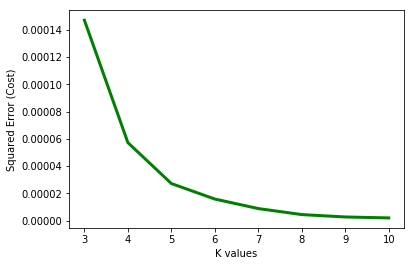

In [70]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i) 
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='g', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [71]:
!conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    yellowbrick-1.0.1          |           py36_0         429 KB  districtdatalabs
    certifi-2019.9.11          |           py36_0         154 KB
    openssl-1.1.1d             |       h7b6447c_3         3.7 MB
    pytest-runner-5.1          |             py_0          13 KB
    ca-certificates-2019.10.16 |                0         131 KB
    ------------------------------------------------------------
                                           Total:         4.4 MB

The following NEW packages will be INSTALLED:

    pytest-runner:   5.1-py_0                             
    yellowbrick:     1.0.1-py36_0         districtdatalabs

The following packages will be UPDATED:

    ca-certificates: 2019.9.11-h

After using Distortion Score Elbow for KMeans Clustering for each K value, it is possible to se that k = 6 is the best value.

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


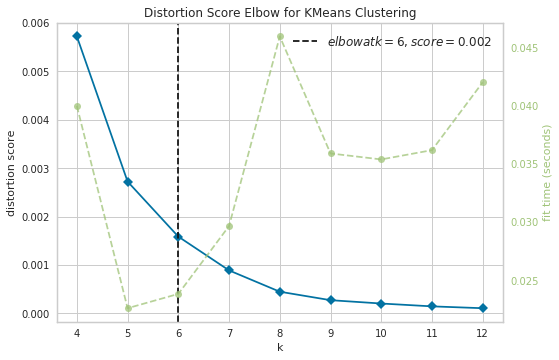

In [72]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()      

Now we cluster the Toronto Neighborhood using K-Means (k = 6)

In [73]:
kclusters = 6
toronto_part_clustering = toronto_part.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)
kmeans.labels_

array([5, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 5, 1,
       5, 0, 3, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 1, 0, 2, 0, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 1, 5, 0, 4, 1, 1, 0, 0, 1, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1,
       5, 0, 3, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 1, 4, 0,
       1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3, 0, 1, 5, 0, 1, 3, 0, 0, 0, 5,
       0, 0, 0, 0, 1, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [74]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_DF
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.000000
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,1.0,0.055556
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.000000


Visualizing Clusters:

In [75]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

Evaluating each cluster:

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.0,0.0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,0.0
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,0.0,0.0
4,Central Toronto,M5N,Roselawn,43.711695,-79.416936,0.0,0.0
5,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529,0.0,0.0
12,East Toronto,M4E,The Beaches,43.676357,-79.293031,0.0,0.0
14,East Toronto,M7Y,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,0.0,0.0
15,East York,M4C,Woodbine Heights,43.695344,-79.318389,0.0,0.0
16,East York,M4G,Leaside,43.709060,-79.363452,0.0,0.0
17,East York,M4H,Thorncliffe Park,43.705369,-79.349372,0.0,0.0


In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,1.0,0.055556
9,Downtown Toronto,M5G,Central Bay Street,43.657952,-79.387383,1.0,0.045977
10,Downtown Toronto,M5W,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,1.0,0.041237
11,Downtown Toronto,M6G,Christie,43.669542,-79.422564,1.0,0.058824
13,East Toronto,M4M,Studio District,43.659526,-79.340923,1.0,0.051282


In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
33,North York,M6B,Glencairn,43.709577,-79.445073,2.0,0.2


In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant


In [80]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
7,Downtown Toronto,M5C,St. James Town,43.651494,-79.375418,4.0,0.030000
8,Downtown Toronto,M5E,Berczy Park,43.644771,-79.373306,4.0,0.035714
35,Queen's Park,M7A,Queen's Park,43.662301,-79.389494,4.0,0.023810


In [81]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,Borough,Postcode,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant
6,Downtown Toronto,M4Y,Church and Wellesley,43.66586,-79.38316,5.0,0.011494


### 4.- RESULTS

a) Regarding to the clusters it is possible to see:
    1) In Cluster 0 the neighborhoods have the smallest number of Italian restaurants.
    2) In Cluster 3 no one neighborhood is close to this centroid.
    3) In Cluster 2 is where more Italian restaurants exist.
    4) In Cluster 5 the restaurants are scattered throughout that neighborhood.
    5) In Cluster 1 is where the neighborhoods have a medium amount of Italian restaurants.
    6) In Cluster 4 is where the neighborhoods have a few amount of Italian restaurants.

    
b) Humber River-Black Creek, York Centre, York South-Weston and Etobicoke Centre are the ridings where more Italian population is present.

c) Among others, Central Bay Street is the neighborhood where more Italian restaurants exist so it will not be an option as a place to open an Italian restaurant.

d) The riding of Humber River—Black Creek include the neighbourhood of Humber Summit which has a considerable amount of Italian population is the ideal neighborhood to open a restaurant of the characteristics proposed since according to the cluster analysis performed, it has a very low concentration of Italian restaurants.


### 5.- DISCUSSION

After the analysis carried out, it can be conclusively concluded that Humber Summit is the neighborhood that would provide the greatest benefits when opening an Italian restaurant since it not only has a relatively high Italian population but also the concentration of Italian restaurants is significantly less than the other neighborhoods.

Although the information is from previous years, it may contain errors and inaccuracies and that many of the data are not completely available on the Wikipedia website, this analysis can be an important reference when deciding to undertake with the opening of a Italian restaurant. In addition, this type of food is widely accepted by many people around the world which can definitely convince any entrepreneur that the option obtained after the analysis is the best.

### 6.- CONCLUSION

During this analysis, there was an opportunity not only to put into practice what was learned, but additional research was also necessary. Ihad the chance to analyze information from different data sources and use the Foursquare API to meet the proposed objective. After this project, the idea of a real analysis becomes much clearer since it involves a lot of information that although it may contain errors, it can lead us to obtain very accurate results. It simply remains to deepen these analyzes since they are very useful when solving everyday problems.